In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import wordcloud 
from wordcloud import WordCloud
import statistics
from collections import Counter
import datetime
import textblob
from textblob import TextBlob
import sklearn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)

# create folder to write data to
CIS545_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS545_2020')
HOMEWORK_FOLDER=os.path.join(CIS545_FOLDER, 'Project')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
fake = pd.read_csv('/content/gdrive/My Drive/CIS545_2020/Project/Fake.csv')
true = pd.read_csv('/content/gdrive/My Drive/CIS545_2020/Project/True.csv')

In [4]:
fake

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [5]:
#Create column with labels
fake["label"] = "fake"
true["label"] = "true"

In [6]:
#Check shapes of dataframes. I scraped 1844 articles to add to this dataset.
print (fake.shape)
print (true.shape)

(23481, 5)
(21417, 5)


In [7]:
#True news has location and publisher, which fake doesn't have. Remove for consistency
true["text"] = true['text'].apply(lambda x: x.partition("-")[2])

In [8]:
#There aren't clear categories, especially within Fake news. It is probably best to remove these categories and use methods such
#as LDA to see if we can get a better sense of the topic
print (fake["subject"].unique())
print (true["subject"].unique())

['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']
['politicsNews' 'worldnews']


In [9]:
fake.drop("subject", axis=1, inplace=True)
true.drop("subject", axis=1, inplace=True)

In [10]:
#Remove articles with only pictures / no text
true = true[true["text"] != ""] 
fake = fake[fake["text"] != ""]

In [11]:
#The datasets are pretty balanced, which is good!
print(fake.shape)
print(true.shape)

(23481, 4)
(21415, 4)


In [12]:
import ipywidgets as widgets
from IPython import display
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(fake.head(5))
with widget2:
    display.display(true.head(5))

# create HBox
hbox = widgets.HBox([widget1, widget2])

# render hbox
hbox

In [13]:
fake.to_csv('fakeForModeling.csv')
!cp fakeForModeling.csv "/content/gdrive/My Drive/CIS545_2020/Project/"

In [14]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   23481 non-null  object
 1   text    23481 non-null  object
 2   date    23481 non-null  object
 3   label   23481 non-null  object
dtypes: object(4)
memory usage: 917.2+ KB


In [15]:
true.to_csv('trueForModeling.csv')
!cp trueForModeling.csv "/content/gdrive/My Drive/CIS545_2020/Project/"

In [16]:
#Get number of articles published by day
daily_true = pd.DataFrame(true.groupby("date").size())
daily_fake = pd.DataFrame(fake.groupby("date").size())
daily_true.reset_index(inplace=True)
daily_fake.reset_index(inplace=True)

In [17]:
daily_true.rename(columns={0: "Number of Articles_true"}, inplace=True)
daily_fake.rename(columns={0: "Number of Articles_fake"}, inplace=True)

In [18]:
#Election day Nov. 8, 2016 - true and fake have peaks there
#Distribution 
from plotly.graph_objs import *
import plotly.graph_objects as go

layout = Layout(
    title='Number of Articles Published, Daily',
    xaxis = go.layout.XAxis(title = go.layout.xaxis.Title(text='Date')),
    yaxis = go.layout.YAxis(title = go.layout.yaxis.Title(text='Number of Articles')),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)')

fig = go.Figure(layout=layout)
fig.add_scatter(x=daily_true['date'], y=daily_true['Number of Articles_true'],mode='lines', line_color='rgb(0,176,246)', name = "True News")
fig.add_scatter(x=daily_fake['date'], y=daily_fake['Number of Articles_fake'],mode='lines', name = "Fake News")
fig.show()


In [19]:
#Both types of articles are around the same length in words, on average
words_per_article_plot_t = true["text"].apply(lambda x: len(x.split()))
stdev_t = statistics.stdev(words_per_article_plot_t)
words_per_article_t = words_per_article_plot_t.sum()/len(true["text"])

words_per_article_plot_f = fake["text"].apply(lambda x: len(x.split()))
stdev_f = statistics.stdev(words_per_article_plot_f)
words_per_article_f = words_per_article_plot_f.sum()/len(fake["text"])

print ("The average number of words in a real news article is ", words_per_article_t)
print ("The average number of words in a fake news article is ", words_per_article_f)

print ("The standard deviation in real news article lengths is ", stdev_t)
print ("The standard deviation in fake news article lengths is ", stdev_f)

The average number of words in a real news article is  382.15699276208267
The average number of words in a fake news article is  423.1979046888974
The standard deviation in real news article lengths is  273.80525497431927
The standard deviation in fake news article lengths is  408.3888904366352


Text(0.5, 1.0, 'Number of Words in Fake News Article')

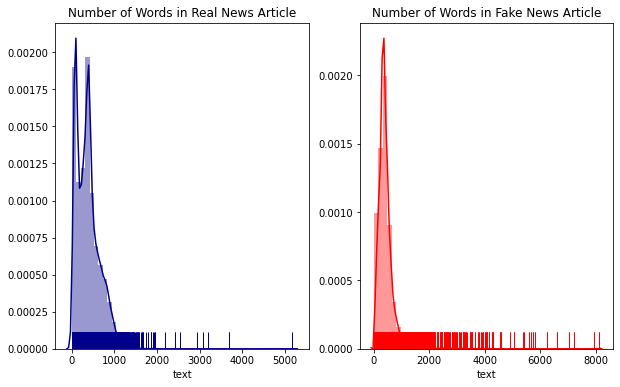

In [20]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.distplot(words_per_article_plot_t, ax = ax[0], color = "darkblue", rug = True).set_title("Number of Words in Real News Article")
sns.distplot(words_per_article_plot_f, ax = ax[1], color = "red", rug = True).set_title("Number of Words in Fake News Article")

In [21]:
article_polarity_true = pd.DataFrame(columns=["article", "sentiment"])
for article in true["text"]:
    article = TextBlob(article)
    article_polarity_true = article_polarity_true.append(pd.Series([article,article.sentiment.polarity], index=article_polarity_true.columns), ignore_index=True)

In [22]:
article_polarity_fake = pd.DataFrame(columns=["article", "sentiment"])
for article in fake["text"]:
    article = TextBlob(article)
    article_polarity_fake = article_polarity_fake.append(pd.Series([article,article.sentiment.polarity], index=article_polarity_fake.columns), ignore_index=True)

In [23]:
print(statistics.mean(article_polarity_true["sentiment"]))
print(statistics.mean(article_polarity_fake["sentiment"]))

0.05305761649822618
0.05947378235243187


Text(0.5, 1.0, 'Fake News Article Sentiments')

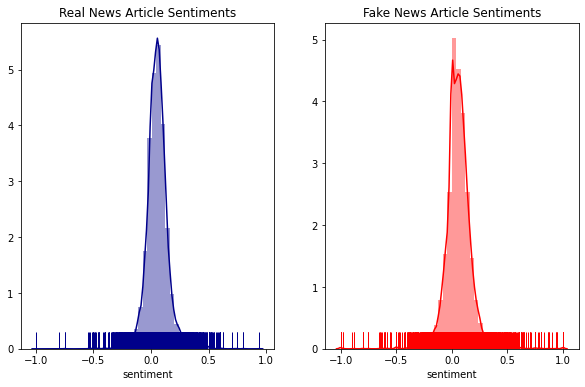

In [24]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.distplot(article_polarity_true["sentiment"], ax = ax[0], color = "darkblue", rug = True).set_title("Real News Article Sentiments")
sns.distplot(article_polarity_fake["sentiment"], ax = ax[1], color = "red", rug = True).set_title("Fake News Article Sentiments")

In [25]:
#Both types of articles are around the same length in words, on average
words_per_headline_plot_t = true["title"].apply(lambda x: len(x.split()))
stdev_t_head = statistics.stdev(words_per_headline_plot_t)
words_per_headline_t = words_per_headline_plot_t.sum()/len(true["title"])

words_per_headline_plot_f = fake["title"].apply(lambda x: len(x.split()))
stdev_f_head = statistics.stdev(words_per_headline_plot_f)
words_per_headline_f = words_per_headline_plot_f.sum()/len(fake["title"])

print ("The average number of words in a real news article is ", words_per_headline_t)
print ("The average number of words in a fake news article is ", words_per_headline_f)

print ("The standard deviation in real news article lengths is ", stdev_t_head)
print ("The standard deviation in fake news article lengths is ", stdev_f_head)

The average number of words in a real news article is  9.95479803875788
The average number of words in a fake news article is  14.732805246795282
The standard deviation in real news article lengths is  1.7003266447007346
The standard deviation in fake news article lengths is  4.335099114452771


Text(0.5, 1.0, 'Number of Words in Fake News Headline')

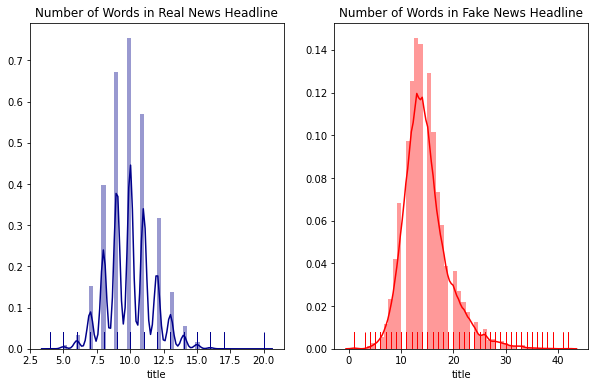

In [26]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.distplot(words_per_headline_plot_t, ax = ax[0], color = "darkblue", rug = True).set_title("Number of Words in Real News Headline")
sns.distplot(words_per_headline_plot_f, ax = ax[1], color = "red", rug = True).set_title("Number of Words in Fake News Headline")

In [27]:
headline_polarity_true = pd.DataFrame(columns=["headline", "sentiment"])
for headline in true["title"]:
    headline = TextBlob(headline)
    headline_polarity_true = headline_polarity_true.append(pd.Series([headline,headline.sentiment.polarity], index=headline_polarity_true.columns), ignore_index=True)

In [28]:
headline_polarity_fake = pd.DataFrame(columns=["headline", "sentiment"])
for headline in fake["title"]:
    headline = TextBlob(headline)
    headline_polarity_fake = headline_polarity_fake.append(pd.Series([headline,headline.sentiment.polarity], index=headline_polarity_fake.columns), ignore_index=True)

In [29]:
#Most negative headlines
a = str(headline_polarity_true.sort_values(by = ["sentiment"], ascending = True, ignore_index=True)["headline"][0])
b = str(headline_polarity_true.sort_values(by = ["sentiment"], ascending = True, ignore_index=True)["headline"][1])
c = str(headline_polarity_true.sort_values(by = ["sentiment"], ascending = True, ignore_index=True)["headline"][2])
d = str(headline_polarity_true.sort_values(by = ["sentiment"], ascending = True, ignore_index=True)["headline"][3])

fig = go.Figure(data=[go.Table(header=dict(values=['Headline']),
                 cells=dict(values=[[a, b, c, d]]))])
fig.show()

In [30]:
#Most positive headlines
a = str(headline_polarity_true.sort_values(by = ["sentiment"], ascending = False, ignore_index=True)["headline"][0])
b = str(headline_polarity_true.sort_values(by = ["sentiment"], ascending = False, ignore_index=True)["headline"][1])
c = str(headline_polarity_true.sort_values(by = ["sentiment"], ascending = False, ignore_index=True)["headline"][2])
d = str(headline_polarity_true.sort_values(by = ["sentiment"], ascending = False, ignore_index=True)["headline"][3])


fig = go.Figure(data=[go.Table(header=dict(values=['Headline']),
                 cells=dict(values=[[a, b, c, d]]))])
fig.show()

In [31]:
print(statistics.mean(headline_polarity_true["sentiment"]))
print(statistics.mean(headline_polarity_fake["sentiment"]))

0.024711633729290746
0.003224071438071588


Text(0.5, 1.0, 'Fake News Headline Sentiments')

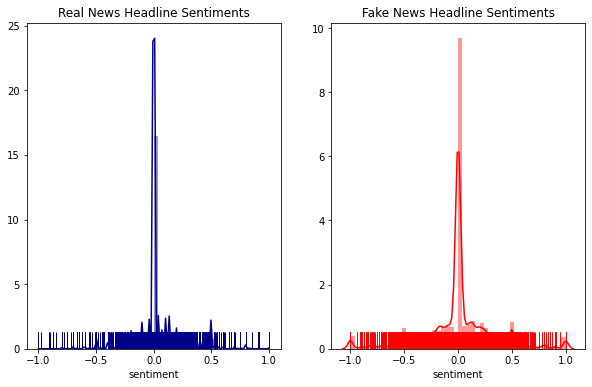

In [32]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.distplot(headline_polarity_true["sentiment"], ax = ax[0], color = "darkblue", rug = True).set_title("Real News Headline Sentiments")
sns.distplot(headline_polarity_fake["sentiment"], ax = ax[1], color = "red", rug = True).set_title("Fake News Headline Sentiments")

In [33]:
import string
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
  
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english', 'arabic'))
stop_words.extend(["said", "reuters", "CNN", "would", "image", "via"]) #extend stopwords to include these words too

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [34]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()  

words_in_t = [] #all tokens in true articles
words_in_f = [] #all tokens in fake articles
words_in_each_article_t = [] #list of true articles, each in tokenized form
words_in_each_article_f = [] #list of fake articles, each in tokenized form

def process(df, word_list, by_article_list):
  for article in (df["text"]):
    words = word_tokenize(article)
    words = [word.lower() for word in words if word.isalpha()] #lowercase
    words = [word for word in words if word not in string.punctuation and word not in stop_words] #punctuation, stopwords
    words = [lemmatizer.lemmatize(word) for word in words] #convert word to root form

    by_article_list.append(words)
    for w in words:
      word_list.append(w)

In [35]:
#NOTE: If rerunning, this cell will take a while
process(fake, words_in_f, words_in_each_article_f)

In [36]:
#NOTE: If rerunning, this cell will take a while
process(true, words_in_t, words_in_each_article_t)

In [37]:
from collections import Counter

bigrams_true = zip(words_in_t, words_in_t[1:])
bigram_counts_true = Counter(bigrams_true)
bigrams_true = pd.DataFrame(bigram_counts_true.most_common(20), columns=["Bigram", "Count"])
bigrams_true

,Bigram,Count
0,"(united, state)",12095
1,"(donald, trump)",10039
2,"(white, house)",8367
3,"(president, donald)",5829
4,"(north, korea)",5628
5,"(prime, minister)",4175
6,"(new, york)",3698
7,"(last, year)",3409
8,"(islamic, state)",3384
9,"(barack, obama)",3341


In [38]:
bigrams_false = zip(words_in_f, words_in_f[1:])
bigram_counts_false = Counter(bigrams_false)
bigrams_false = pd.DataFrame(bigram_counts_false.most_common(20), columns=["Bigram", "Count"])
bigrams_false

,Bigram,Count
0,"(donald, trump)",15360
1,"(hillary, clinton)",6786
2,"(white, house)",6349
3,"(united, state)",6209
4,"(new, york)",4209
5,"(president, obama)",3854
6,"(president, trump)",3770
7,"(fox, news)",3243
8,"(barack, obama)",2238
9,"(century, wire)",1924


In [39]:
trigrams_true = zip(words_in_t, words_in_t[1:], words_in_t[2:])
trigram_counts_true = Counter(trigrams_true)
trigrams_true = pd.DataFrame(trigram_counts_true.most_common(20), columns=["Trigram", "Count"])
trigrams_true

,Trigram,Count
0,"(president, donald, trump)",5768
1,"(president, barack, obama)",2903
2,"(respond, request, comment)",854
3,"(president, vladimir, putin)",789
4,"(state, rex, tillerson)",673
5,"(secretary, state, rex)",672
6,"(national, security, adviser)",635
7,"(former, president, barack)",629
8,"(russian, president, vladimir)",612
9,"(speaker, paul, ryan)",607


In [40]:
trigrams_false = zip(words_in_f, words_in_f[1:], words_in_f[2:])
trigram_counts_false = Counter(trigrams_false)
trigrams_false = pd.DataFrame(trigram_counts_false.most_common(20), columns=["Trigram", "Count"])
trigrams_false

,Trigram,Count
0,"(donald, trump, realdonaldtrump)",1692
1,"(new, york, time)",1514
2,"(black, life, matter)",1248
3,"(president, donald, trump)",978
4,"(news, century, wire)",939
5,"(president, united, state)",914
6,"(president, barack, obama)",882
7,"(video, screen, capture)",729
8,"(century, wire, say)",727
9,"(new, york, city)",611


In [41]:
wordcounts_t = Counter(words_in_t)
wordcounts_f = Counter(words_in_f)

In [42]:
mostcommon_t = Counter(wordcounts_t).most_common(20)
mostcommon_f = Counter(wordcounts_f).most_common(20)

t_plot = dict(mostcommon_t)
mostcommon_t = pd.DataFrame(mostcommon_t, columns = ["Word", "Count"])
mostcommon_t = mostcommon_t.reset_index(drop=True)
mostcommon_t = mostcommon_t['Word'].tolist()

f_plot = dict(mostcommon_f)
mostcommon_f = pd.DataFrame(mostcommon_f, columns = ["Word", "Count"])
mostcommon_f = mostcommon_f.reset_index(drop=True)
mostcommon_f = mostcommon_f['Word'].tolist()

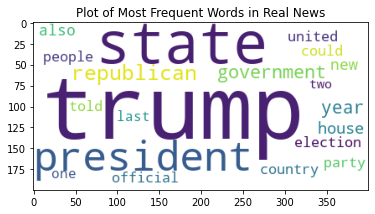

In [43]:
t_wc = WordCloud(max_words=25,relative_scaling=1,background_color ='white', normalize_plurals=False).generate_from_frequencies(t_plot)

plt.imshow(t_wc)
plt.title("Plot of Most Frequent Words in Real News")
plt.show()

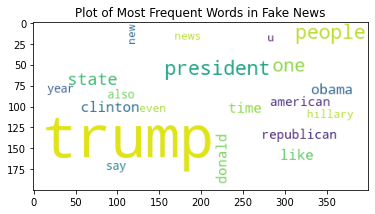

In [44]:
f_wc = WordCloud(max_words=25,relative_scaling=1,background_color ='white', normalize_plurals=False).generate_from_frequencies(f_plot)

plt.imshow(f_wc)
plt.title("Plot of Most Frequent Words in Fake News")
plt.show()

In [45]:
#Of the top 20 words in each class, 9 words are common 
len(set(mostcommon_t) & set(mostcommon_f))

9

In [46]:
#Get tokenized forms of all articles (true and fake) in one dataframe
X = []
for a in words_in_each_article_t:
  X.append(a)
for b in words_in_each_article_f:
  X.append(b)

In [47]:
#Get labels of all articles (true and fake) in one dataframe
y = pd.concat([true["label"], fake["label"]])
y = [1 if x == "fake" else 0 for x in y] #1 and 0 for ease of tokenizing

In [48]:
articles = pd.DataFrame(X)
y = pd.DataFrame(y, columns=["label"])

In [49]:
articles.to_csv('articles.csv')
!cp articles.csv "/content/gdrive/My Drive/CIS545_2020/Project/"

y.to_csv('labels.csv')
!cp labels.csv "/content/gdrive/My Drive/CIS545_2020/Project/"

In [50]:
import sklearn.model_selection as ms

#Create 80-20 train test split
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size = 0.2, random_state=1)

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Keep words that appear in greater than 10% of documents. Override preprocessor and implement on list of words
#in each article in order to keep the words we have cleaned for earlier
tfidf = TfidfVectorizer(min_df = 0.1, preprocessor = ' '.join)

#Implement on train dataset
response_train = tfidf.fit_transform(X_train) #This is the Sparse Document-Term Matrix
feature_names_train = tfidf.get_feature_names()
dense_train = response_train.todense() #This is the Dense Document-Term Matrix
denselist_train = dense_train.tolist()

In [52]:
df_train = pd.DataFrame(denselist_train, columns=feature_names_train)
df_train

,according,act,action,added,administration,agency,already,also,america,american,among,another,around,asked,attack,back,barack,become,believe,bill,business,call,called,came,campaign,candidate,case,change,chief,city,clear,clinton,come,comment,committee,company,congress,conservative,could,country,...,supporter,take,talk,thing,think,though,three,thursday,time,today,told,took,top,trump,trying,tuesday,twitter,two,united,use,used,video,vote,want,war,washington,way,wednesday,week,well,went,whether,white,without,woman,work,world,year,yet,york
0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.082334,0.0,0.000000,0.000000,0.075592,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.090141,0.000000,0.0,0.0,0.0,0.000000,0.077832,0.000000,0.000000,0.0,0.000000,0.473674,0.064067,0.000000,...,0.000000,0.147797,0.000000,0.0,0.0,0.0,0.0,0.0,0.060542,0.0,0.000000,0.088313,0.000000,0.051248,0.0,0.000000,0.096971,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.631513,0.000000,0.0,0.000000,0.0,0.000000
1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.203878,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.172364,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2,0.000000,0.000000,0.130338,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.097460,0.0,0.000000,0.0,0.239142,0.000000,0.000000,0.0,0.00000,0.136254,0.128458,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.121403,0.000000,0.0,0.257009,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.087543,0.000000,0.000000,0.143619,0.0,0.000000,0.000000,0.094400,0.194349,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.104936,0.000000,0.000000,0.112642,0.0,0.000000,0.102171,0.0,0.000000,0.000000,0.0,0.081782,0.0,0.000000
3,0.093335,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.066248,0.096596,0.410701,0.0,0.097233,0.0,0.100776,0.000000,0.000000,0.0,0.11549,0.114836,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.108407,0.0,0.0,0.0,0.000000,0.091917,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.077557,...,0.000000,0.174543,0.110137,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.073782,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.079562,0.000000,0.109245,0.108673,0.000000,0.0,0.175320,0.0,0.000000,0.088441,0.000000,0.082966,0.000000,0.0,0.000000,0.172221,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,0.165768,0.000000,0.000000,0.0,0.000000,0.194295,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.154999,0.195608,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.141305,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.157076,0.000000,0.000000,0.000000,0.0,0.185455,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35911,0.000000,0.000000,0.000000,0.0,0.143507,0.000000,0.0,0.000000,0.282501,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(preprocessor = ' '.join, vocabulary = feature_names_train)

#Implement on test dataset
response_test = tfidf.fit_transform(X_test) #This is the Sparse Document-Term Matrix
feature_names_test = tfidf.get_feature_names()
dense_test = response_test.todense() #This is the Dense Document-Term Matrix
denselist_test = dense_test.tolist()

In [54]:
df_test = pd.DataFrame(denselist_test, columns=feature_names_test)
df_test

,according,act,action,added,administration,agency,already,also,america,american,among,another,around,asked,attack,back,barack,become,believe,bill,business,call,called,came,campaign,candidate,case,change,chief,city,clear,clinton,come,comment,committee,company,congress,conservative,could,country,...,supporter,take,talk,thing,think,though,three,thursday,time,today,told,took,top,trump,trying,tuesday,twitter,two,united,use,used,video,vote,want,war,washington,way,wednesday,week,well,went,whether,white,without,woman,work,world,year,yet,york
0,0.048765,0.0,0.000000,0.000000,0.353569,0.22466,0.057275,0.069130,0.000000,0.000000,0.000000,0.050299,0.000000,0.000000,0.109129,0.000000,0.05769,0.119833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.055736,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.080141,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.054171,0.000000,0.037500,0.0,0.000000,0.053575,0.0,0.220916,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.057021,0.000000,0.000000,0.000000,0.056920,0.000000,0.0,0.000000,0.043841,0.000000,0.0,0.000000,0.000000,0.166320,0.0,0.050334,0.05088,0.142080,0.000000,0.0
1,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068487,0.000000,0.000000,0.0,0.000000,0.159639,0.000000,0.000000,0.082073,0.0,0.000000,0.075802,0.00000,0.000000,0.0,0.0,0.056170,0.057385,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.053703,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.058340,0.000000,0.000000,0.000000,0.000000,0.300464,0.065339,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0
2,0.066365,0.0,0.000000,0.000000,0.137480,0.00000,0.000000,0.047040,0.000000,0.115898,0.080362,0.068452,0.000000,0.141915,0.074258,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.144474,0.000000,0.000000,0.000000,0.0,0.148597,0.000000,0.080107,0.077831,0.000000,0.0,0.064278,0.000000,0.00000,0.080645,0.0,0.0,0.000000,0.163599,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.073723,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.214749,0.000000,0.068917,0.0,0.000000,0.172944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.073064,0.181620,0.000000,0.0,0.000000,0.00000,0.048340,0.000000,0.0
3,0.000000,0.0,0.000000,0.135332,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.401174,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.133512,0.000000,0.000000,0.000000,0.000000,0.000000,0.311015,0.0,0.000000,0.000000,0.000000,0.129513,0.000000,0.0,0.106960,0.000000,0.00000,0.000000,0.0,0.0,0.088823,0.272234,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.086314,0.000000,0.0,0.071470,0.000000,0.000000,0.0,0.092255,0.095928,0.000000,0.129130,0.000000,0.000000,0.000000,0.128902,0.000000,0.0,0.117207,0.099284,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.160878,0.000000,0.0
4,0.000000,0.0,0.184457,0.000000,0.081818,0.00000,0.000000,0.055990,0.081551,0.068974,0.000000,0.000000,0.000000,0.084457,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.148309,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.085739,0.09481,0.287965,0.0,0.0,0.127067,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.168956,0.000000,0.0,0.061739,0.000000,0.0,0.255606,0.000000,0.000000,0.0,0.065988,0.000000,0.089954,0.000000,0.000000,0.169927,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.079607,0.0,0.173930,0.000000,0.000000,0.0,0.000000,0.00000,0.057537,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [55]:
#This is the final data to be used for training models
df_train.to_csv('training_data.csv')
!cp training_data.csv "/content/gdrive/My Drive/CIS545_2020/Project/"

In [56]:
#This is the final data to be used for testing models
df_test.to_csv('testing_data.csv')
!cp testing_data.csv "/content/gdrive/My Drive/CIS545_2020/Project"

In [57]:
y_train = pd.DataFrame(y_train, columns=["label"])
y_test = pd.DataFrame(y_test, columns=["label"])

In [58]:
#Final labels to be used for training models
y_train.to_csv('train_labels.csv')
!cp train_labels.csv "/content/gdrive/My Drive/CIS545_2020/Project/"

In [59]:
#Final labels to be used for testing models
y_test.to_csv('test_labels.csv')
!cp test_labels.csv "/content/gdrive/My Drive/CIS545_2020/Project/"

From medium Getting Real with Fake news